Sequential Decision Making
==========================



## Sequential Decision Making



<div class="abstract" id="orgb532ff9">
<p>
In this lab we will look at black-box optimisation. What we want to convey with this material is how uncertainty is a quantification of uncertainty that goes far beyond the idea of "noise". Uncertainty is what guides our learning so that we can reduce our ignorance. To be able to show this concept we will need some more advanced probabilistic objects. However, the specifics of these objects is not important its how we use them. The task that we will focus on is the of <i>black-box optimisation</i>. The idea is that we have a function that we want to optimise, i.e. find the minima, the tricky thing is that we do not know the form of the function but we can evaluate it. This means that we will use a statistical model to specify a <i>surrogate</i> for the unknown function and use our belief in this surrogate as a guide to our search. When we build statistical models we quantify our knowledge using probabilities which specifies our beliefs. This means that we specify not only <i>what we know</i> but also <i>how well we know</i> it. The main thing that we want to get across in this lab is showing how useful and important this concept can be.
</p>

</div>

Lets assume that we have a function $f(\mathbf{x})$ that is *explicitly* unknown that we want to find the minima of. We will further assume that it is possible to evaluate the function but that each evaluation is expensive. This means that the problem that we have on our hands is to *search* the input domain for the extreme point but do so in a manner that we minimise the number of evaluation that we make of the function. One approach to address this type of problem is to use a technique called *Bayesian Optimisation* and that is the focus of this lab. 

Searching for the extremum of explicitly unknown functions is problem that appears in many applications. The first use of Bayesian methods for approaching this is usually attributed to ([Movckus 1975](#orgf824d30)) a Lithuanian mathematician. This important work was slightly overlooked at the time but recently it has gotten the attention that it deserves. The reason for this is that with increasingly complicated models with enormous cost for training being able to efficiently utilise the data have become very important. The use of Bayesian optimisation for learning how to set parameters in complicated unstructured models is often attributed to ([Snoek, Larochelle, and Adams 2012](#org698b44b)) who really put these types of techniques at the forefront of modern machine learning. Even though the are used everywhere this is often not reported particularly well, as an example it took several years for the authors of AlphaGo to properly publish and discuss the importance of Bayesian optimisation for their task ([Chen et al. 2018](#org6f15148)).  

The main part of a Bayesian optimisation system is a loop where we in an iterative manner decided on new locations to evaluate the objective function. The two components of the loop are a surrogate model of the function which describes how we believe the function looks in every part of the domain and a acquisition function which decides based on our current belief of what the function is where to sample next. Importantly this makes it key to have uncertainty in our system as we need to have a belief about what the function value is everywhere. Gaussian processes is a rich class of function priors that we will use them for our surrogate model. Before we go trough GPs lets begin by making the problem more concrete.

Lets assume that we want to find the minima of a function $f(x)$,

we will at each time have observed a set of values of the function at specific function locations, we will refer to this as the data $\mathcal{D} = \{\mathbf{x}, \mathbf{f} \}$. Furthermore at any point we have a current best estimate, we will refer to this location in the data space as $\hat{x}$ and its function value as $\hat{f} = f(\hat{x})$. We will use a surrogate model to describe our beliefs about the function $f$. We will use a Gaussian process to do so which means that we have access to a distribution $p(f\vert x, \mathcal{D})$ which is the predictive posterior of the Gaussian process.

## Bibliography



### Surrogate Model



We will use a Gaussian process as a surrogate model for the function $f$. Gaussian processes are generalisations of the finite Gaussian distribution defined over an infinite index set. Where we can use the Gaussian distribution to specify beliefs over a finite set of parameters as in the linear regression example we can therefore use Gaussian processes to specify beliefs over infinite structures as the output of a function. We will not cover the specific details of Gaussian processes in this lab but rather focus on what they provide us with. If you are interested in the details you can look [here](https://mlatcl.github.io/mlphysical/slides/l48-mlpw-03.pdf) for an introduction.



#### Gaussian processes



A Gaussian processes is completely specified by a mean function $\mu(x)$ that encodes what our belief in the output value at a specific location $x=x_i$ and a covariance function $k(x_i,x_j)$ that specifies how informative the function value at $x_i$ is for determining the function value at $x_j$. Below we have will implement a Gaussian process and draw samples from the prior. The left plot shows the samples and the right shows the prior they are drawn from. You can try to play around with the `lengthscale` and `varSigma` parameter of the covariance function to see how the distribution changes.



(-4.0, 4.0)

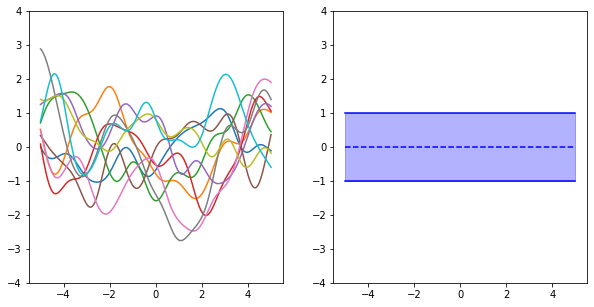

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from scipy.spatial.distance import cdist

def rbf_kernel_compute(x1,x2,lengthScale,varSigma,noise=0.00001):
     if x2 is None:
          d = cdist(x1,x1)
     else:
          d = cdist(x1,x2)

     K = np.zeros(d.shape)
     K = varSigma*np.exp(-np.power(d,2)/lengthScale)

     if x2 is None:
          K = K + noise*np.diag(np.ones(K.shape[0]))
     return K

# parameters for the covariance function
lengthscale = 1
varSigma = 1

# evaluation points of the function
x1 = np.linspace(-5,5,300).reshape(-1,1)

# compute the covariance function
K11 = rbf_kernel_compute(x1,x1,lengthscale,varSigma)
# compute the mean function
mu = np.zeros(x1.shape[0])

# sample from the prior distribution
y_prior_samp = np.random.multivariate_normal(mu, K11, 10)

# plot results
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(121)
ax.plot(x1,y_prior_samp.T)
ax.set_ylim([-4,4])
ax = fig.add_subplot(122)
ax.plot(x1, mu, linestyle='--', color='blue')
ax.plot(x1, mu+np.diag(K11), color='blue')
ax.plot(x1, mu-np.diag(K11), color='blue')
ax.fill_between(x1.flatten(),mu-np.diag(K11),mu+np.diag(K11),color='blue',alpha=0.3)
ax.set_ylim([-4,4])

Having specified a prior distribution above our next goal is to observe some data and derive a posterior distribution. The code below does this and plots samples from the posterior, the right plot shows the posterior variance over each location.



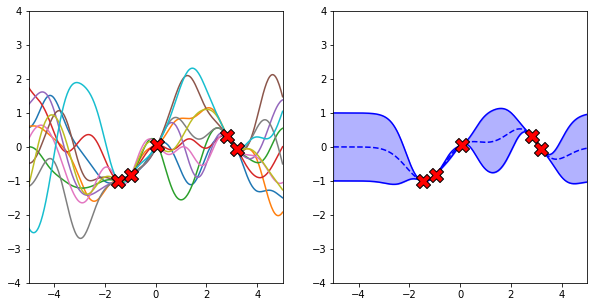

In [14]:
x2 = 2*np.random.randn(5).reshape(-1,1)
y2 = np.sin(x2)
K22 = rbf_kernel_compute(x2,x2,lengthscale,varSigma)
K12 = rbf_kernel_compute(x1,x2,lengthscale,varSigma)

mu_posterior = K12.dot(np.linalg.inv(K22)).dot(y2)
var_posterior = K11 - K12.dot(np.linalg.inv(K22).dot(K12.T))

y_posterior_samp = np.random.multivariate_normal(mu_posterior.flatten(), var_posterior, 10)

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(121)
ax.plot(x1, y_posterior_samp.T, zorder=1)
ax.scatter(x2, y2, s=200, color='red', marker='X',zorder=2,edgecolor='black')
ax.set_xlim([np.min(x1),np.max(x1)])
ax.set_ylim([-4,4])

ax = fig.add_subplot(122)
ax.plot(x1, mu_posterior.flatten(), linestyle='--', color='blue',zorder=1)
ax.plot(x1, mu_posterior.flatten()+np.diag(var_posterior), color='blue',zorder=1)
ax.plot(x1, mu_posterior.flatten()-np.diag(var_posterior), color='blue',zorder=1)
ax.fill_between(x1.flatten(),
                mu_posterior.flatten()-np.diag(var_posterior),
                mu_posterior.flatten()+np.diag(var_posterior),
                color='blue',alpha=0.3,zorder=1)
ax.set_xlim([np.min(x1),np.max(x1)])
ax.set_ylim([-4,4])
ax.scatter(x2, y2, s=200, color='red', marker='X',zorder=2,edgecolor='black')

The important part with the Gaussian process defined above is not how it works but that we are able to specify a prior distribution over the space of functions and then derive a posterior distribution after having seen data. Importantly this posterior distribution quantifies our belief of what the function value is at **any** point in the input domain. We will now proceed to show how we can use this to define a sequential decision problem to find the minima of an explicitly unknown function. In order to do so we need to implement a function that can return the mean and the variance at a set of locations `x_star` of a Gaussian process parametrised by `theta` where we have observed locations `x` with function values `f`.



In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from scipy.spatial.distance import cdist

def rbf_kernel_compute(x1,x2,lengthScale,varSigma,noise=0.00001):
     if x2 is None:
          d = cdist(x1,x1)
     else:
          d = cdist(x1,x2)

     K = np.zeros(d.shape)
     K = varSigma*np.exp(-np.power(d,2)/lengthScale)

     if x2 is None:
          K = K + noise*np.diag(np.ones(K.shape[0]))
     return K


def surrogate_belief(x,f,x_star,theta):
     K = rbf_kernel_compute(x,x,theta[0],theta[1])
     K_starstar = rbf_kernel_compute(x_star,x_star,theta[0],theta[1])
     K_star = rbf_kernel_compute(x_star,x,theta[0],theta[1])

     mu_star = K_star.dot(np.linalg.inv(K)).dot(f)
     varSigma_star = np.diag(K_starstar - K_star.dot(np.linalg.inv(K).dot(K_star.T)))

     return mu_star, varSigma_star

Now when we have our surrogate model set up it is time to move on to the second component, the acquisition function.



### Aquisition Function



The idea of the aqusition function is that it encodes the strategy of how we should utilise the knowledge that we currently have in order to decide on where to query the function. The design of this function is where we balance the two important factors, *exploration* where we learn about new things, and *exploitation* where we utilise what we currently know. There are many different acquisition functions to use and we will here only look at one of them but in principle they all describe a *utility-value* across the whole input domain of how much we will "gain" by querying the function in this specific place.



#### Expected Improvement



The most commonly used acquisition function is *Expected Improvement* ([Movckus 1975](#org7afc5f5)). The idea underlying expected improvement is that the utility of a location in the input domain is relative to how much lower we expect the function value at this point to be compared to the current best estimate. This means that the utility function $u(x)$ can be defined as follows,
    $$
    u(x) = \textrm{max}(0, f(x_*)-f(x))
    $$
    This means that we have a reward for every location in the space where the function $f(x)$ is smaller than the current best estimate $f(x_*)$. Now as we do not know $f(x)$ we want to use our knowledge from the surrogate model $f$. This we can do by taking the expectation of the utility function over our belief in the function as,
    $$
    \alpha(x) = \mathbb{E}\left[u(x)\vert x, \mathcal{D} \right] = \int_{-\infty}^{f(x_*)} (f(x_*)-f(x))\mathcal{N}(f\vert \mu(x), k(x,x))\textrm{d}f.
    $$
    Note how the upper limit of the integral is the current best estimate of the function thereby implementing the max operator.

One of the nice things about Expected improvement is that we can evaluate the expectation in closed form resulting in the following acquisition function,
$$
    \alpha(x) = \underbrace{(f(x_*) - \mu(x))\Psi(f(x_*)\vert \mu(x), k(x,x))}_{\text{exploitation}} + \underbrace{k(x,x)\mathcal{N}(f(x_*)\vert \mu(x), k(x,x))}_{\text{exploration}}
    $$
$$
    \Psi(f(x_*)\vert \mu(x), k(x,x)) = \int_{-\infty}^{f(x_*)} \mathcal{N}(f\vert \mu(x), k(x,x))\textrm{d}f.
    $$
The function $\Psi$ is the *cumulative density function* or *cdf* of the Gaussian which has the following form,
$$
    \Psi(x\mid \mu, \sigma) = \frac{1}{2}\left(1+\textrm{erf}\left(\frac{x-\mu}{\sigma\sqrt{2}} \right) \right),
    $$
where $\textrm{erf}(\cdot)$ is the [error-function](https://en.wikipedia.org/wiki/Error_function). You do not have to implement this yourself as it is available as `scipy.stats.norm.cdf`. Now we want to choose points in the input domain that will maximise the acquisition function. Looking at the function that we have derived we can see that it includes two terms, the first term can be increased by picking an $x$ value such that the difference between $f(x_*)-\mu(x)$ is large. In effect this is *exploiting* the knowledge that we currently have about the function. The second term can be increased by finding a location in the input domain such that $k(x,x)$ is large, i.e. the variance at this location is high. In effect this is *exploration* as we are looking for locations where we are uncertain of what the value is. As you can see these two terms formulates a specific balancing between the two key aspects of search, *exploration* and *exploitation*.

Lets now implement the acquisition function that should return a scalar value for each location in the input space. The function takes as input `mu` and `varSigma` being the mean and the variance of the posterior of the surrogate model at locations `x` which is the set of candidates for where to pick the next function evaluation and `f_best` as the current best value of the function according to our objective.

## Bibliography



In [16]:
from scipy.stats import norm

def expected_improvement(f_best, mu, varSigma):
    
    alpha = np.zeros(mu.shape)
    for i in range(0,alpha.shape[0]):
        alpha[i] = (f_best-mu[i])*norm.cdf(f_best,mu[i],np.sqrt(varSigma[i]))+ varSigma[i]*norm.pdf(f_best,mu[i],np.sqrt(varSigma[i]))
        
    return alpha

We now have all the parts that we need in order to implement our Bayesian optimisation loop, the surrogate model using a Gaussian process and the acquisition function using expected improvement.



### Experiments



We will now write up the Bayesian optimisation loop that we will iterate through. The first thing we need is a function to evaluate. As we want to be able to play around with the function a bit we will add a set of possible arguments. The functions is the classical Forrester function that was proposed in ([Forrester 2008](#org0e884eb)). Initially we will drop the linear and constant term but you can alter them to test the performance. For the experiment we will limit the domain to $x\in[0,1]$.

## Bibliography



In [17]:
def f(x, A=1, B=0, C=0):
       return A*(6*x-2)**2*np.sin(12*x-4) + B*(x-0.5) + C

The next thing that we will do is to decide on a finite set of possible evaluations of the function. The function that we are using is a function in $\mathbb{R}$ what we will do is to divide up this space into a finite set of locations and then our aim is to find at which one of these points we have the minimal value of the function. If we call this set $\mathbf{X}$ we will now start our loop by taking a random set of starting points, compute the predictive posterior over the remaining points, compute the acquisition for all the points not included in the model, pick the location with the highest acquisition and include this into the modelling set.



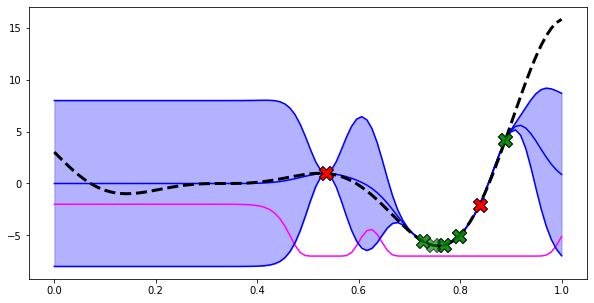

In [18]:
# fix random seed to get reproducible results
np.random.seed(42)

# create evaluation set
X_all = np.linspace(0,1,100).reshape(-1,1)
X = X_all

# pick random start values
N_start = 2
ind = np.random.permutation(X.shape[0])[:N_start]
x_eval = X[ind].reshape(-1,1)
f_eval = f(x_eval)

# remove evaluation points from test set
X = np.delete(X, ind).reshape(-1,1)

# specify prior
theta = np.array([0.005,8])

# number of steps in loop
N_loop = 6

# perform loop
for i in range(0,N_loop):
    f_best = np.min(f_eval)
    mu, varSigma = surrogate_belief(x_eval,f_eval,X,theta)
    alpha = expected_improvement(f_best, mu, varSigma)
    ind = np.argmax(alpha)
    f_eval = np.append(f_eval, f(X[ind])).reshape(-1,1)
    x_eval = np.append(x_eval, X[ind]).reshape(-1,1)
    X = np.delete(X, ind).reshape(-1,1)

# plot results
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)

mu_alpha, varSigma_alpha = surrogate_belief(x_eval, f_eval, X,theta)
f_best = np.min(f_eval)
alpha = expected_improvement(f_best, mu_alpha, varSigma_alpha)
ax.plot(X, alpha*5/np.max(alpha)-7, color='magenta')

mu, varSigma = surrogate_belief(x_eval, f_eval, X_all,theta)
ax.plot(X_all.flatten(), f(X_all),color='black',linestyle='--', linewidth=3.0,zorder=3)
ax.plot(X_all.flatten(), mu, color='blue',linestyle='-',zorder=2)
ax.plot(X_all.flatten(), mu.flatten()+varSigma, color='blue',linestyle='-',zorder=2)
ax.plot(X_all.flatten(), mu.flatten()-varSigma, color='blue',linestyle='-',zorder=2)
ax.fill_between(X_all.flatten(), mu.flatten()+varSigma, mu.flatten()-varSigma, color='blue', alpha=0.3,zorder=2)
ax.scatter(x_eval[:N_start], f_eval[:N_start], s=200, color='red', marker='X',zorder=4,edgecolor='black')

for i in range(0,N_loop-1):
    ax.scatter(x_eval[N_start:N_start+i+1], f_eval[N_start:N_start+i+1], s=200, color='green', marker='X',zorder=4,edgecolor='black',alpha=(i/N_loop))

When you got the loop implemented you can try and see how good result you generally get in a fixed number of iterations. Then you compare this result with taking the same number of locations uniformly at random from the index set and evaluating them. If you compare the runs how often do you get a better value with the Bayesian optimisation approach compared to the random search? Now we can alter this question slightly, given that you have a current best estimate using BO, how many random samples do you need in order to get an equally good result?



### Summary



Hopefully you have seen that having the concept of uncertainty can be really useful in order to direct a sequential search strategy as in Bayesian optimisation. Hopefully the simple one dimensional example provided you with an intuition and I hope that it feels like quite a natural way of how to search for an optima and that you can relate to the balancing between exploration and explotation in how you would most likely approach a problem.

